<div align="center">
<b>Vysoké učení technické v Brně</b><br />
<i>Signály a systémy</i><br />
<i>2022/2023</i>
</center>

<h1><center>Projekt – Syntetický klavír</center></h1>

<center>
<i>Onegen Something</i><br />
<i>(xonege99)</i>
</center>


In [40]:
# Importy
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.markers as mark
import scienceplots
import soundfile as sf
import scipy as sp
from scipy import signal
from scipy.io import wavfile
from scipy.signal import periodogram
from scipy.fft import fftfreq, fftshift, fft, ifft, fft2, ifft2
from IPython.display import display, Audio, Math, Latex
plot.style.use(['science', 'notebook', 'grid'])

Tento projekt, zameriavajúci sa na spektrálnu analýzu, je písaný v programovacom jayzku Python (Jupyter Notebook) — zdrojový súbor `projekt.ipynb` sa nachádza v zložke `src`. Projekt využíva knižnice [`numpy`](https://numpy.org/) a [`scipy`](https://scipy.org/) na výpočty, knižnicu [`soundfile`](https://pypi.org/project/soundfile/) na načítanie zvukového súboru, a knižnice [`matplotlib`](https://matplotlib.org/), [`IPython`](https://ipython.org/) a [`scienceplots`](https://pypi.org/project/SciencePlots/) na vykreslovanie grafov. Konečným cieľom projektu bolo pomocou analýzy súboru [`klavir.wav`](https://www.fit.vutbr.cz/study/courses/ISS/public/proj2022-23/klavir.wav) vytvoriť syntetický klavír. Pri jednotlivých krokoch som mal zadané tri konkrétne tóny, ktoré som mal použiť:
<br />

<table align="center">
<tbody>
  <tr>
    <td rowspan="2"><a href="https://www.fit.vutbr.cz/study/courses/ISS/public/proj2022-23/personal/xonege99.txt" target="_blank">xonege99.txt</a></td>
    <td>36</td>
    <td>43</td>
    <td>83</td>
  </tr>
  <tr>
    <td>65.41</td>
    <td>98.00</td>
    <td>987.77</td>
  </tr>
</tbody>
</table>


## 1: Základy


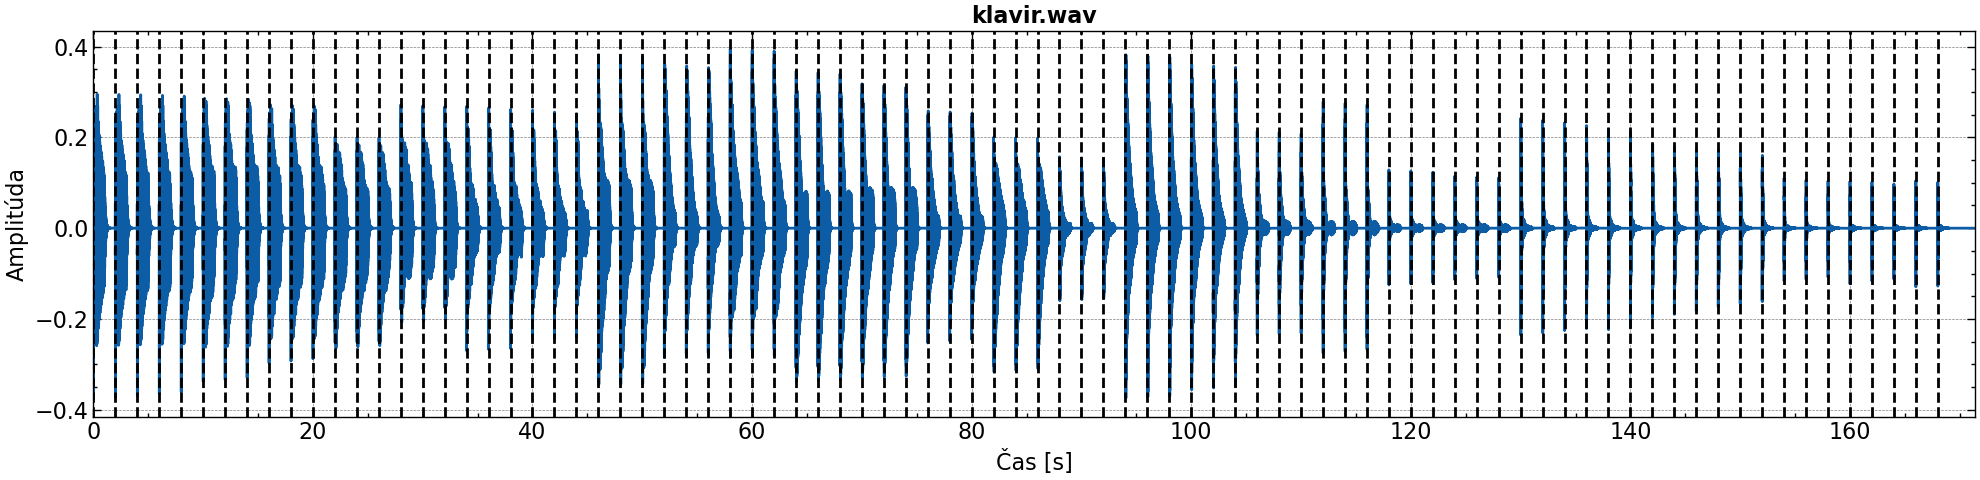

In [41]:
# Načítanie zvukového súboru 'klavir.wav'
sound_data, sample_rate = sf.read('../audio/klavir.wav')
time = np.arange(sound_data.size) / sample_rate

# Vykreslenie celého zvukového signálu
plot.figure(figsize=(20, 5), layout='tight')
plot.plot(time, sound_data)
plot.title('klavir.wav', weight='bold')
plot.gca().set(xlabel='Čas [s]', ylabel='Amplitúda')
plot.gca().set_xlim(min(time), max(time))
cutoffs = np.array(np.arange(0, 170, 2))  # Medze tónov (2 sekundy na tón)
cutoffs = cutoffs.astype(int)
[plot.axvline(cutoff, color='k', linestyle='--') for cutoff in cutoffs]
plot.show()

Po načítaní je zvukový súbor rozdelený na jednotlivé tóny s dĺžkou 0,5 sekundy.


In [42]:
# Načítanie signálov
START_MIDI = 24
END_MIDI = 108
SKIP_LENGTH = 0.25
SAMPLE_LENGTH = 0.5
TONE_LENGTH = 2
TONE_COUNT = END_MIDI - START_MIDI + 1

tones = np.arange(START_MIDI, END_MIDI + 1)
samples_per_cutoff = int(sample_rate * SAMPLE_LENGTH)
samples_per_tone = int(sample_rate * TONE_LENGTH)
tone_matrix = np.zeros((END_MIDI + 1, samples_per_cutoff))

sample_from = int(sample_rate * SKIP_LENGTH)
sample_to = sample_from + samples_per_cutoff
for tone in tones:
    sample = sound_data[sample_from:sample_to]
    sample = sample - np.mean(sample)
    tone_matrix[tone, :] = sample
    sample_from += samples_per_tone
    sample_to += samples_per_tone

<table align="center">
<thead>
  <tr>
    <th colspan="2">klavir.wav</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Počet tónov</td>
    <td>85</td>
  </tr>
  <tr>
    <td>Dĺžka tónu</td>
    <td>2 s</td>
  </tr>
  <tr>
    <td>Dĺžka celkom</td>
    <td>170 s</td>
  </tr>
  <tr>
    <td>Vzorkovacia frekvencia</td>
    <td>48 kHz</td>
  </tr>
</tbody>
</table>

Z celkovej vzorkovacej frekvencie $f_s$ je možné vypočítať čas medzi vzorkami — **vzorkovaciu periódu** $T$:

$$
T = \frac{1}{f_s} = \frac{1}{48000} = 2,08\overline{3}\cdot10^{-5}\text{ s}
$$

Pri analýze zvukového signálu je základom tento signál frekvenčne analyzovať, teda previesť na spektrum zobrazujúce aké frekvencie sú v signály obsiahnuté a do akej miery. Toto spektrum sa zobrazuje ako logaritmická **spektrálna hustota výkonu** $G[k]$.

$$
G[k] = 10 \log_{10} \frac{|X[k]|^2}{N}
$$

Na tento výpočet sa používa **rýchla Fourierova transformácia** (FFT), čo je zrýchlený algoritmus výpočtu diskrétnej Fourierovej transformácie (DFT).


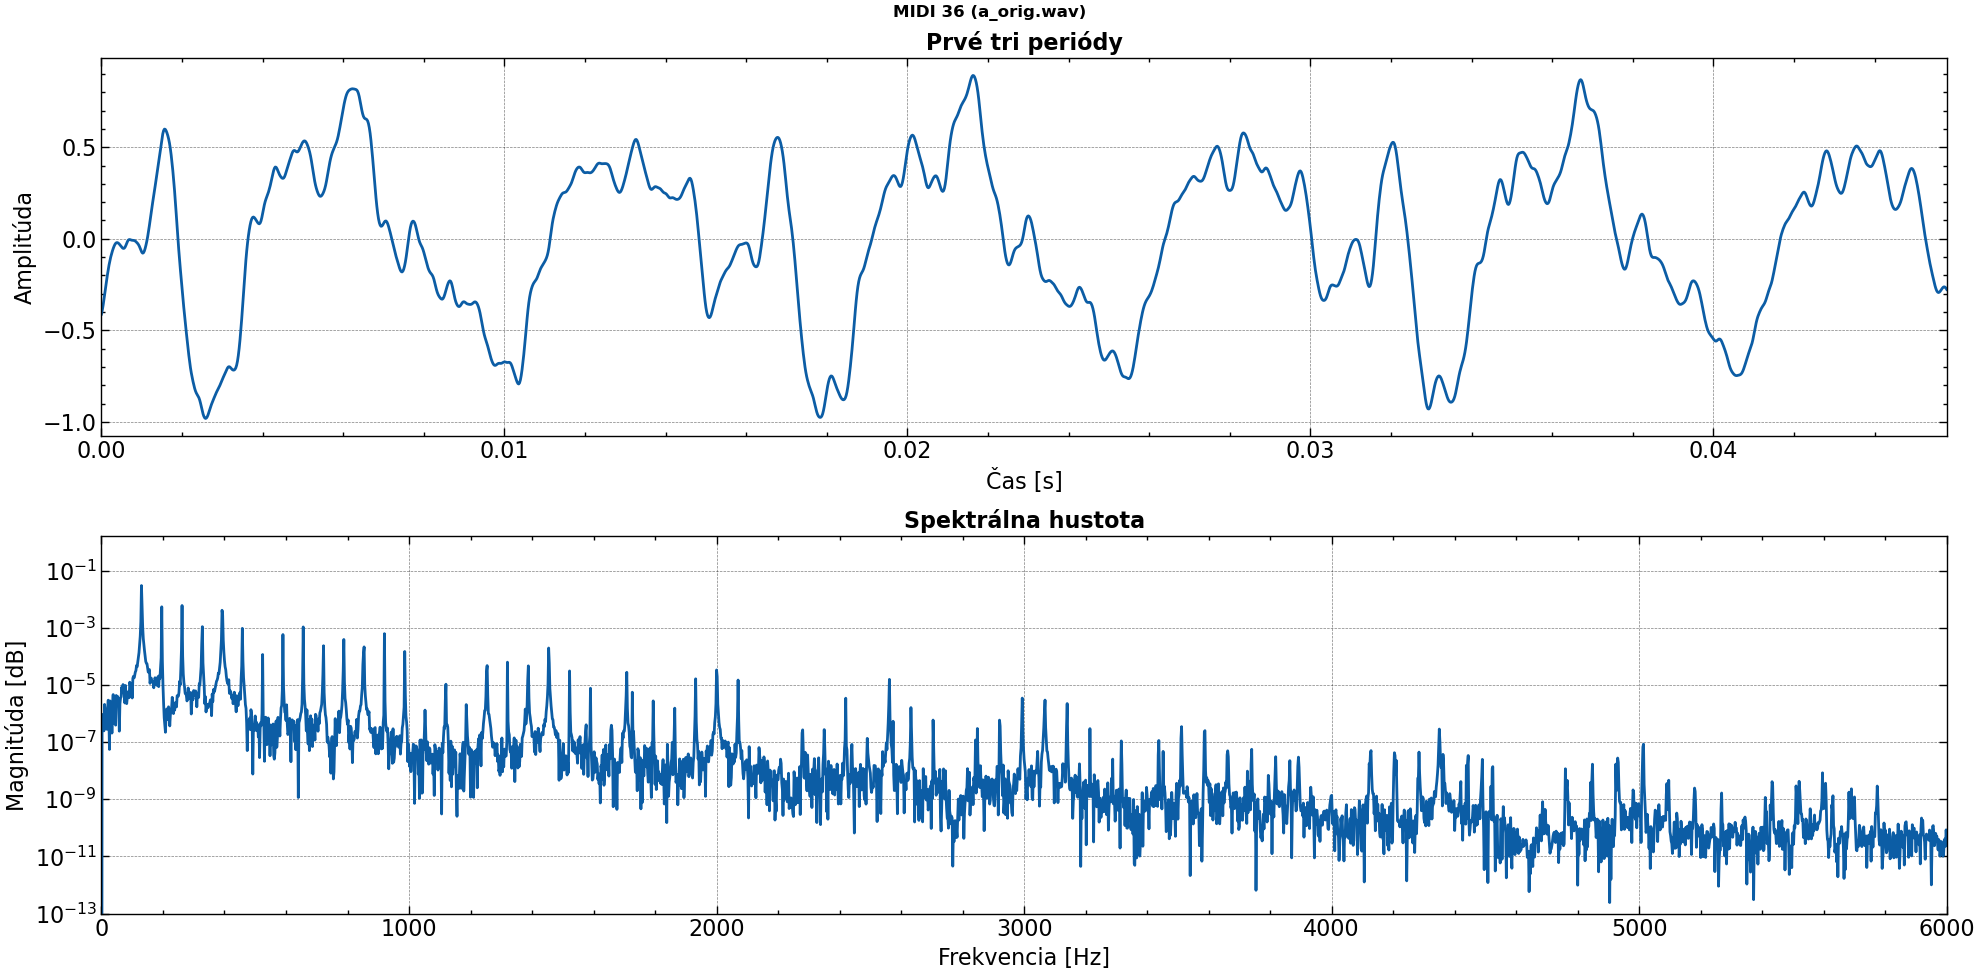

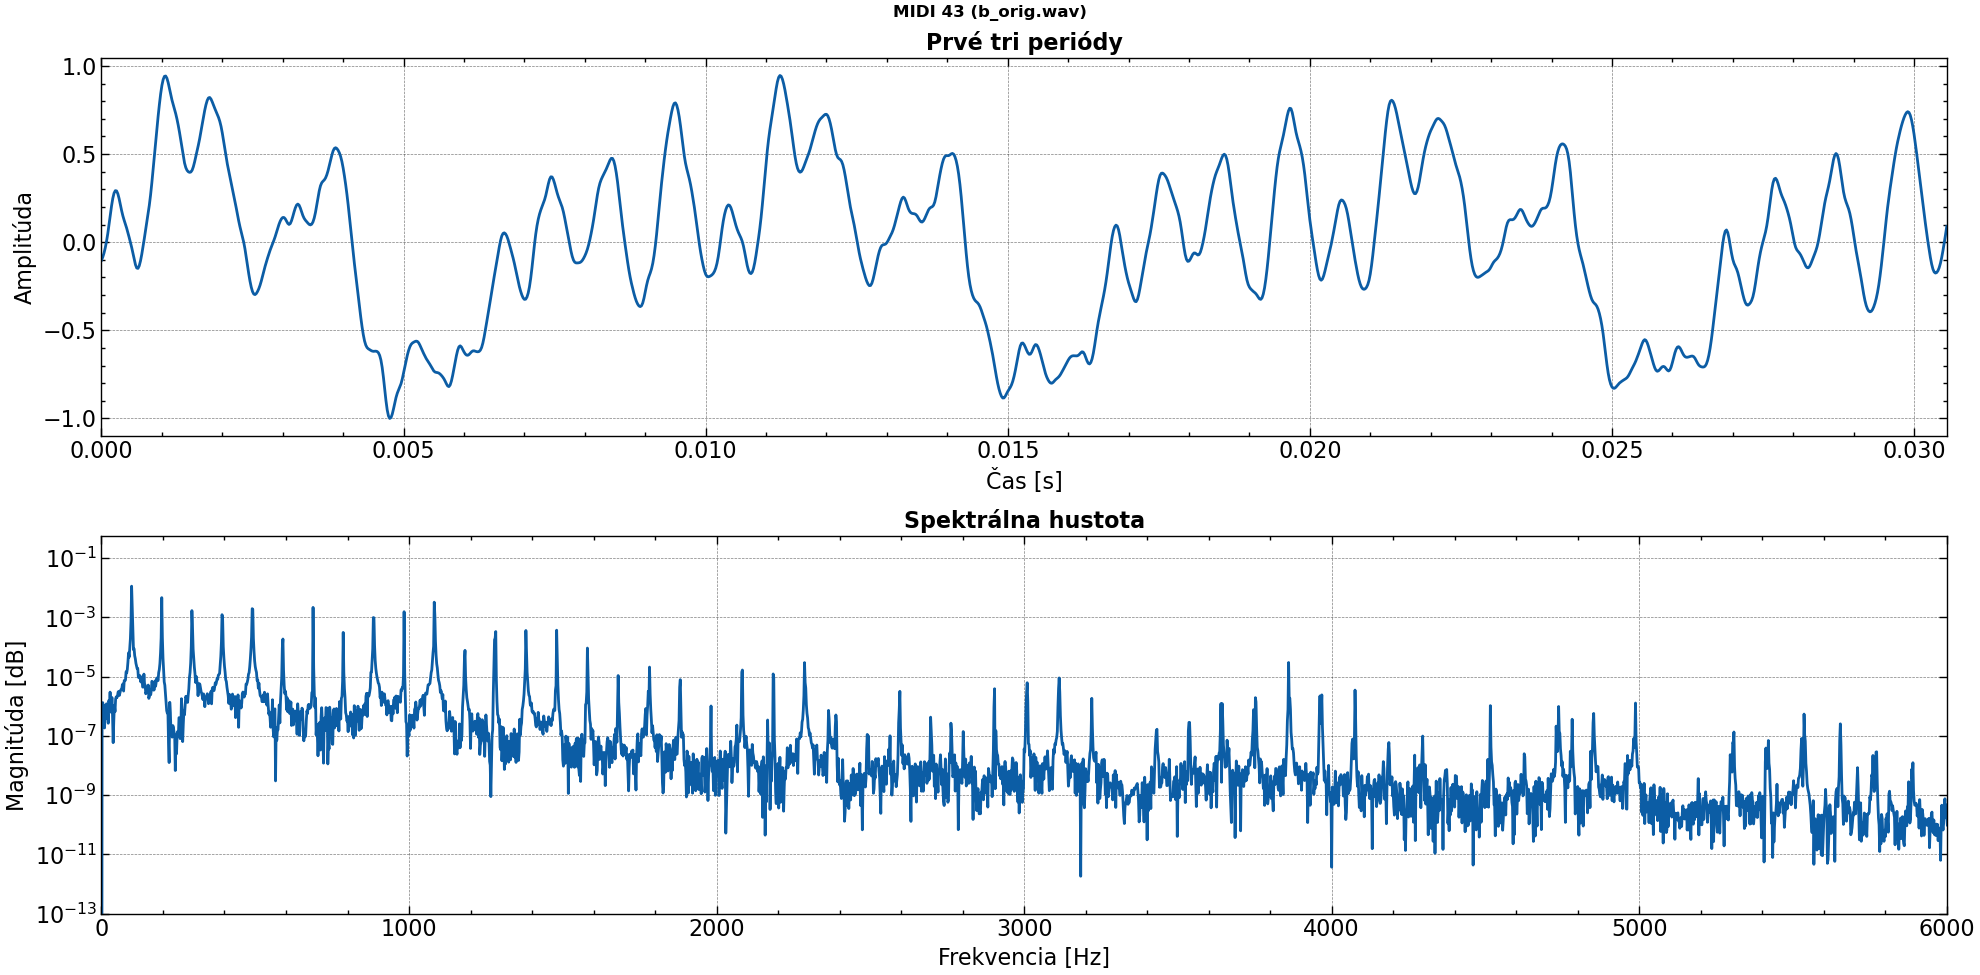

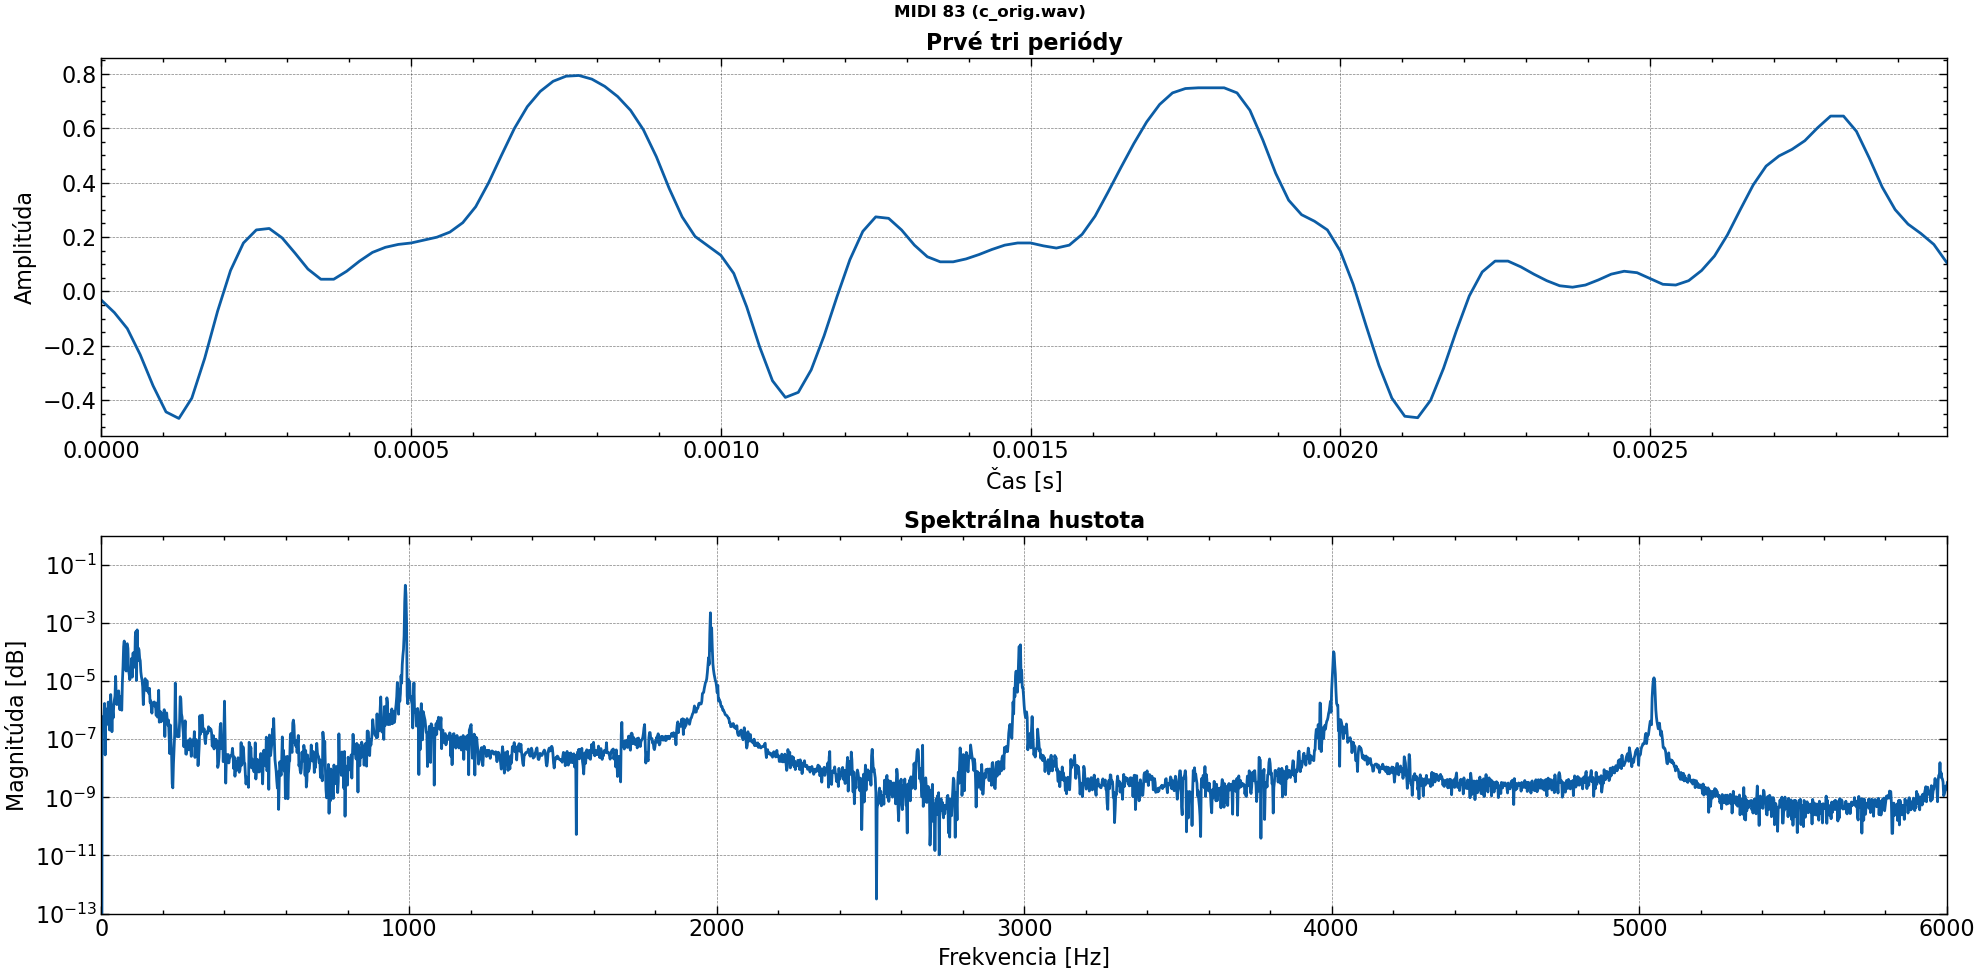

In [43]:
# Frekvencie z midi.txt - použité na výpočet samples_per_period a zistenie odchýlky f_0
MIDI_FREQ = np.append(np.zeros(START_MIDI), [32.70, 34.65, 36.71, 38.89,
                                             41.20, 43.65, 46.25, 49.00,
                                             51.91, 55.00, 58.27, 61.74,
                                             65.41, 69.30, 73.42, 77.78,
                                             82.41, 87.31, 92.50, 98.00,
                                             103.83, 110.00, 116.54, 123.47,
                                             130.81, 138.59, 146.83, 155.56,
                                             164.81, 174.61, 185.00, 196.00,
                                             207.65, 220.00, 233.08, 246.94,
                                             261.63, 277.18, 293.66, 311.13,
                                             329.63, 349.23, 369.99, 392.00,
                                             415.30, 440.00, 466.16, 493.88,
                                             523.25, 554.37, 587.33, 622.25,
                                             659.26, 698.46, 739.99, 783.99,
                                             830.61, 880.00, 932.33, 987.77,
                                             1046.50, 1108.73, 1174.66, 1244.51,
                                             1318.51, 1396.91, 1479.98, 1567.98,
                                             1661.22, 1760.00, 1864.66, 1975.53,
                                             2093.00, 2217.46, 2349.32, 2489.02,
                                             2637.02, 2793.83, 2959.96, 3135.96,
                                             3322.44, 3520.00, 3729.31, 3951.07,
                                             4186.01
                                             ])
MYTONE_MIDI = [36, 43, 83]  # Moje MIDI tóny
mytones = [tone_matrix[tone] for tone in MYTONE_MIDI]

for i, tone in enumerate(mytones):
    # Ustálenie a normalizácia tónov
    tone = tone - np.mean(tone)
    tone = tone / np.max(np.abs(tone))

    # Výpočet čas a amplitúda
    tone_time = np.arange(0, len(tone) / sample_rate, 1 / sample_rate)
    samples_per_period = int(sample_rate / MIDI_FREQ[MYTONE_MIDI[i]])
    tone_time_3T = tone_time[:samples_per_period * 3]
    amplitude_3T = tone[:samples_per_period * 3]

    # Výpočet periodogramu
    frequencies, tgram = periodogram(tone, sample_rate)

    # Vykreslenie
    fig, (ax1, ax2) = plot.subplots(
        2, 1, figsize=(20, 10), layout='tight')
    filename = chr(ord('a') + i) + '_orig.wav'
    fig.suptitle(
        'MIDI ' + str(MYTONE_MIDI[i]) + ' (' + filename + ')', weight='bold')

    ax1.plot(tone_time_3T, amplitude_3T)
    ax1.set_xlim(min(tone_time_3T), max(tone_time_3T))
    ax1.set_title('Prvé tri periódy', weight='bold')
    ax1.set_xlabel('Čas [s]')
    ax1.set_ylabel('Amplitúda')

    ax2.plot(fftshift(frequencies), fftshift(tgram))
    ax2.semilogy()
    ax2.set_xlim(0, len(frequencies) // 2)
    ax2.set_ylim(1e-13)
    ax2.set_title('Spektrálna hustota', weight='bold')
    ax2.set_xlabel('Frekvencia [Hz]')
    ax2.set_ylabel('Magnitúda [dB]')

    plot.show()

    # Uloženie do súboru
    display(Audio(tone, rate=sample_rate))
    sf.write('../audio/' + filename, tone, sample_rate)

## 2: Určenie základnej frekvencie

**Základná frekvencia** $f_0$ je frekvencia tvorená periodickým signálom, ktorá sa v spektre tohoto signálu vyskytuje najvýraznejšie. V prípade zvukového tónu ide o frekvenciu, ktorú pri počutí zvukovej vlny vnímame ako hlavnú. Na jej výpočet sú možné dva spôsoby — _diskrétna Fourierova transformácia_ a _autokorelácia_ — ktoré majú na istý rozsah tónov odlyšnú presnosť.

### 2.1: Fourierova transformácia (DFT)

Prvý spôsob určenia $f_0$ je použitie **diskrétnej Fourierovej transformácie** (DFT):

$$
c[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{- \jmath \frac{2\pi}{N}kn}
$$

Použitím DFT na zvukový signál tónu získavame frekvenčnú doménu signálu, na ktorej je vidno zložky tvoriace tento signál. Najväčšia z týchto frekvenčných zložiek — _dominantná frekvencia_ — je _zvyčajne_ aj základnou frekvenciou.

$$
f_0 = f_{max} = \max{\left| \sum_{n=0}^{N-1} x[n] \cdot e^{- \jmath \frac{2\pi}{N}kn} \right|}
$$


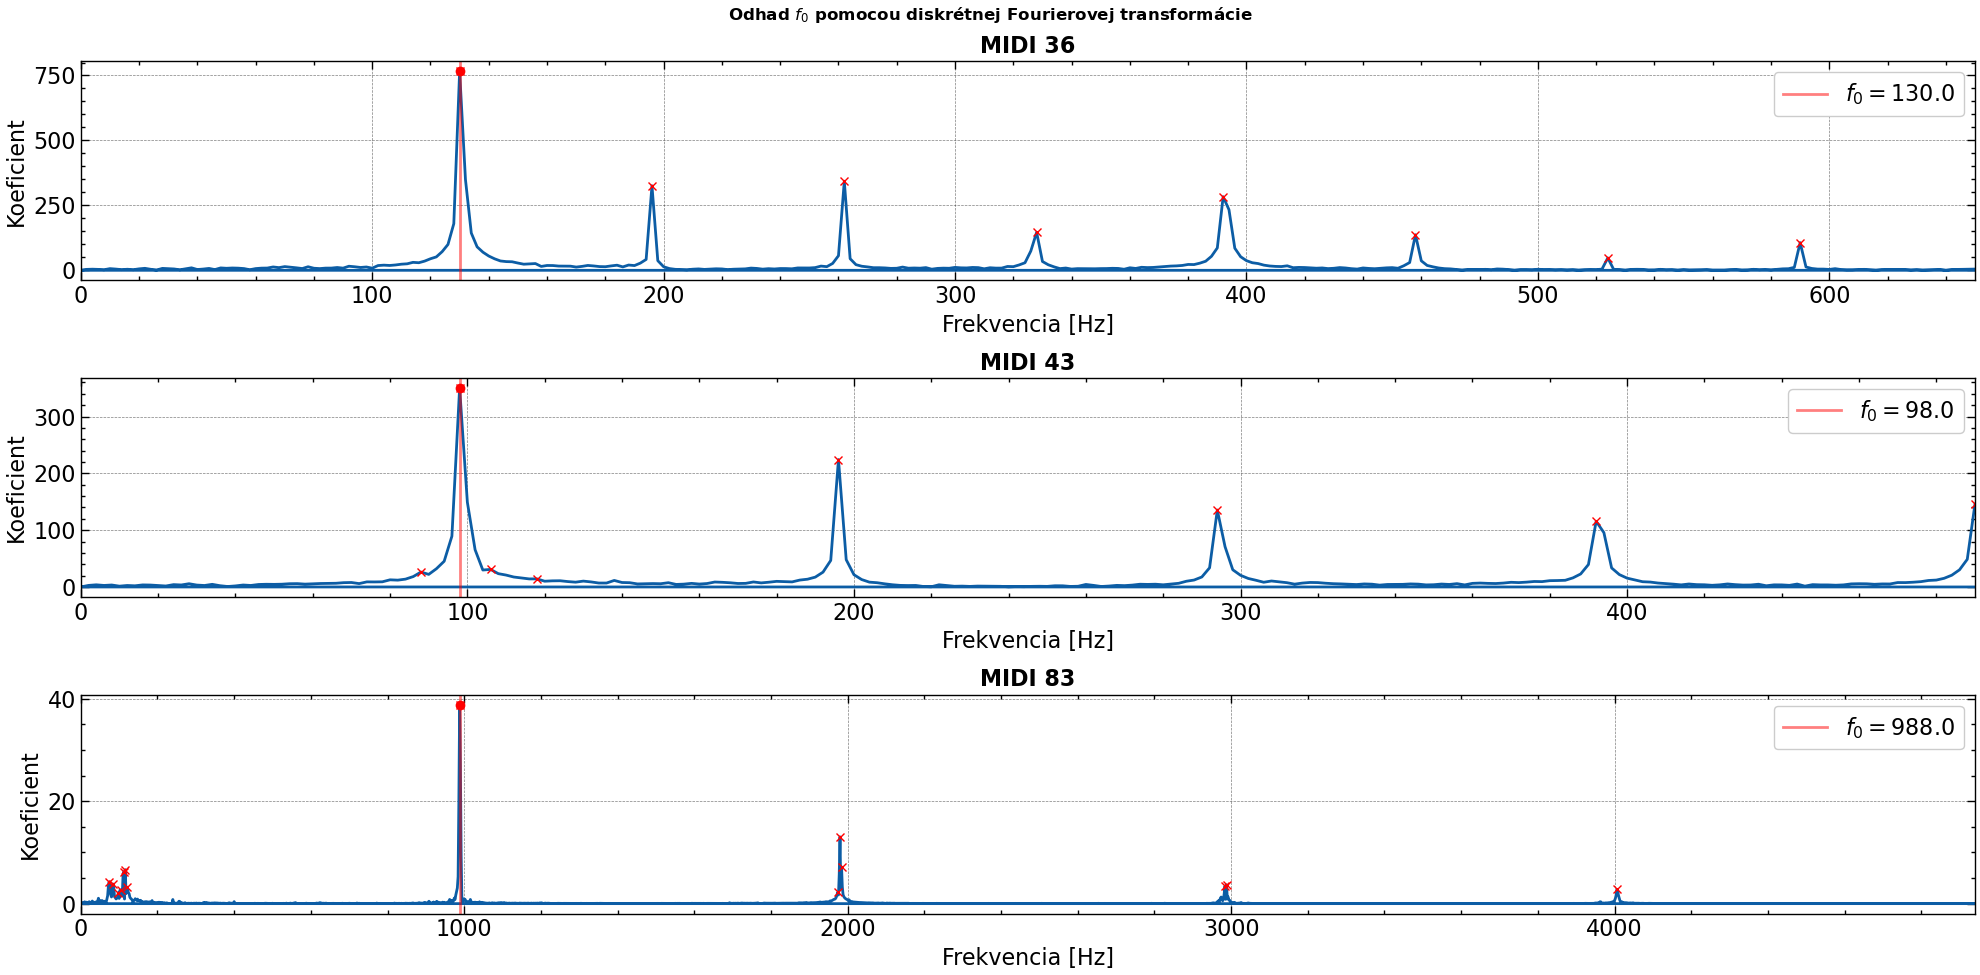

In [44]:
def fundamental_freq_dft(tone, sample_rate):
    if np.max(tone) == 0:
        return 0.0, None, None, None, None
    tone_dft = np.abs(fft(tone))
    tone_dft = tone_dft[:len(tone_dft)//2]
    frequencies = np.arange(len(tone_dft)) * (sample_rate / len(tone))
    peaks, _ = signal.find_peaks(tone_dft)
    maxpeak_i = np.argmax(tone_dft[peaks])
    maxpeak_x = frequencies[peaks][maxpeak_i]
    return maxpeak_x, maxpeak_i, peaks, tone_dft, frequencies


# Zistenie f_0 každého tónu
f0_dft = np.zeros(END_MIDI + 1)
fig, ax = plot.subplots(3, 1, figsize=(20, 10), layout='tight')
fig.suptitle(
    'Odhad $f_0$ pomocou diskrétnej Fourierovej transformácie', weight='bold')
for i, tone in enumerate(tone_matrix):
    if np.max(tone) == 0:
        continue

    # Výpočet
    f0_dft[i], i_peak, peak_all, tone_dft, freq_all = fundamental_freq_dft(
        tone, sample_rate)
    f0_error = round(abs(f0_dft[i] - MIDI_FREQ[i]), 2)  # odchýľka

    # Vykreslenie
    if (i in MYTONE_MIDI):
        i_plt = MYTONE_MIDI.index(i)
        ax[i_plt].plot(fftshift(freq_all), fftshift(tone_dft))
        peak_all_filt = [
            peak for peak in peak_all if tone_dft[peak] > max(tone_dft)/25]
        ax[i_plt].plot(frequencies[peak_all_filt],
                       tone_dft[peak_all_filt], 'rx')
        ax[i_plt].axvline(f0_dft[i], color='r', alpha=0.5,
                          label='$f_0 =$' + str(f0_dft[i]))
        ax[i_plt].plot(frequencies[peak_all][i_peak],
                       tone_dft[peak_all][i_peak], 'ro')
        ax[i_plt].set_xlim(0, frequencies[peak_all[i_peak]]*5)
        ax[i_plt].set_title('MIDI ' + str(i), weight='bold')
        ax[i_plt].set_xlabel('Frekvencia [Hz]')
        ax[i_plt].set_ylabel('Koeficient')
        ax[i_plt].legend(loc='upper right')

Po použití tejto metódy na nájdenie $f_0$ na všetky tóny je možné určiť presnosť tejto metódy porovnaním s hodnotami v súbory `midi.txt`:

$$
E = \left| f_{0_{calculated}} - f_{0_{true}} \right|
$$

<table align="center">
<tbody>
  <tr>
    <td><b>MIDI</b></td>
    <td>24–40</td>
    <td>41–52<br>56–108</td>
    <td>53–55</td>
  </tr>
  <tr>
    <td><b>Odchýlka<br>[Hz]</b><br></td>
    <td>33 až 166</td>
    <td>0 až 3</td>
    <td>176 až 200</td>
  </tr>
</tbody>
</table>

Obecne sa ukázalo, že táto metóda je nepresná pre tóny z nižšou frekvenciou, kde odchýľka môže dosiahnuť skoro až 200 Hz, zatiaľ čo na vyšších tónoch je odchýlka značne menšia (do 2 Hz, pravdepodobne malé rozladenie klavíru). Túto vysokú odchýľku spôsobuje jav zvaný **[efekt chýbajúceho základného tónu](https://cs.wikipedia.org/wiki/Efekt_chyb%C4%9Bj%C3%ADc%C3%ADho_z%C3%A1kladn%C3%ADho_t%C3%B3nu)** — čo je jav, kde podtóny _naznačujú_ existenciu základnej frekvencie $f_0$, ktorá sa však v zvukovom signály nenachádza. Ku príkladu, v mojom tóne MIDI 36 (nota C2, správna $f_0$ je 65,41 Hz) bola detekovaná $f_0$ 130 Hz, čo však korešponduje s tónom o oktávu vyššie (dvojnásobok; MIDI 48, nota C3). Následujúce vrcholy viditeľné v grafe sú taktiež posunuté o oktávu (teda sú násobky správnej $f_0$) — 192 Hz, 262 Hz, 325 Hz a tak ďalej. Toto naznačuje, že správna $f_0$ je 65 Hz aj keď sa v signály nenachádza — napriek tomu túto neprítomnú frekvenciu ľudské ucho ju vníma ako základnú (tzv. _psychoakustický jav_).

Tento fakt však Fourierova transformácia neberie do úvahy — vrcholy sú zobrazené len pri frekvenciách, ktoré sa v signály skutočne nachádzajú. Na nižšie tóny je teda vhodnejšia iná metóda, ktorá berie do úvahy akékoľvek harmonické frekvencie — autokorelácia.

### 2.1: Autokorelácia (ACF)

Autokorelácia je korelácia (závislosť, podobnosť) signálu s opozdenou kópiou samého seba — teda určuje ako sa signál podobá sám sebe v rôznych časových bodoch.

$$
R(m) = \sum_{n=0}^{N-1-m} s(n) \cdot s(n+m)
$$

$$
R(m) = \sum_{n=m}^{N-1} s(n) \cdot s(n-m)
$$

Z výslednej autokorelačnej funkcie $R(m)$ sa potom určuje hodnota _lag_ hľadaním indexu jeho maxima:

$$
lag = \arg{\max{R(m)}} \newline
$$

$$
f_0 = \frac{1}{lag} \cdot F_s
$$


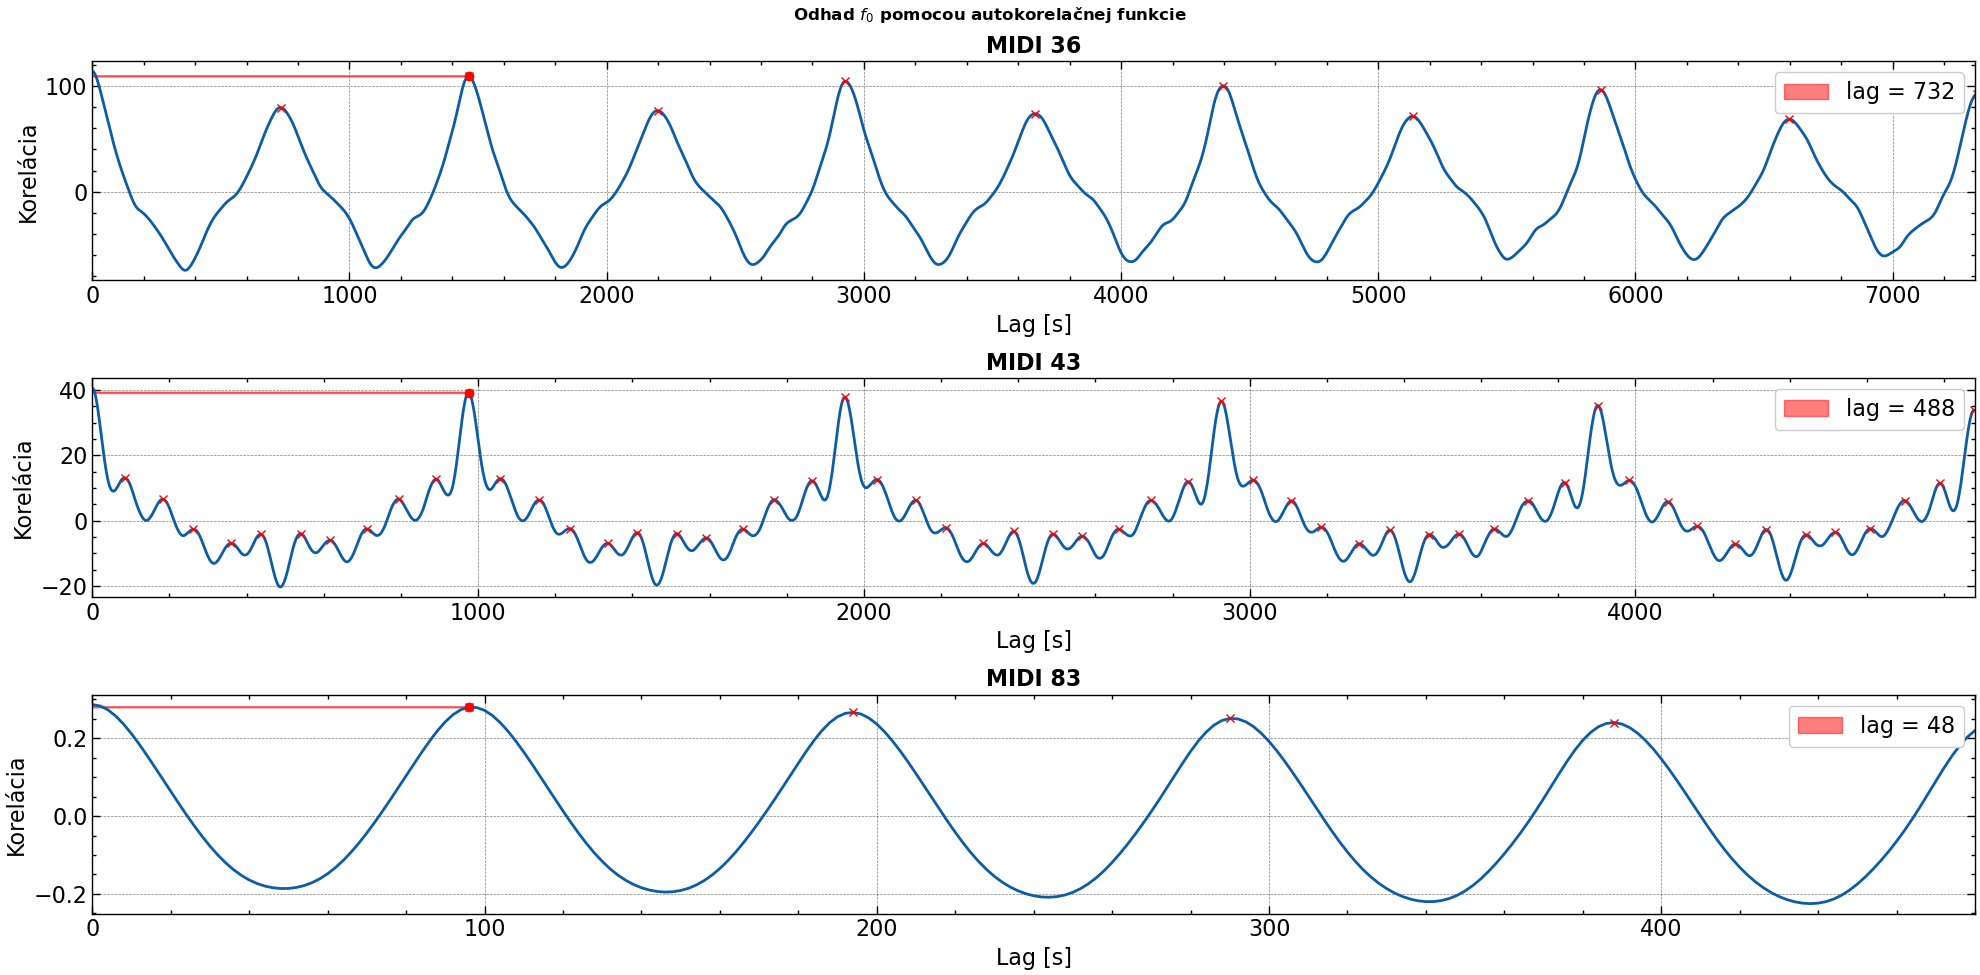

In [45]:
def fundamental_freq_autocorr(tone, sample_rate):
    if np.max(tone) == 0:
        return 0.0, 0.0, None, None
    acorr = signal.correlate(tone, tone, mode='full', method='direct')
    acorr = acorr[len(acorr)//2:]
    peaks, _ = signal.find_peaks(acorr)
    if len(peaks) < 1:
        return 0.0, 0.0, peaks, acorr
    lag_i = np.argmax(acorr[peaks])
    f0 = (1 / peaks[lag_i]) * sample_rate
    return f0, lag_i, peaks, acorr


# Zistenie f_0 každého tónu
f0_acorr = np.zeros(END_MIDI + 1)
fig, ax = plot.subplots(3, 1, figsize=(20, 10), layout='tight')
fig.suptitle('Odhad $f_0$ pomocou autokorelačnej funkcie', weight='bold')
for i, tone in enumerate(tone_matrix):
    if np.max(tone) == 0:
        continue

    # Výpočet
    f0_acorr[i], i_peak, peak_all, acorr = fundamental_freq_autocorr(
        tone, sample_rate)
    f0_error = round(abs(f0_acorr[i] - MIDI_FREQ[i]), 2)  # odchýľka

    # Vykreslenie
    if (i in MYTONE_MIDI):
        i_plt = MYTONE_MIDI.index(i)
        plot_freq = np.arange(len(acorr)) * (sample_rate / len(tone))
        ax[i_plt].plot(plot_freq, acorr)
        ax[i_plt].plot(plot_freq[peak_all], acorr[peak_all], 'rx')
        arrw = (2 * acorr[peak_all[i_peak]]) / 200
        ax[i_plt].arrow(0, acorr[peak_all[i_peak]], plot_freq[peak_all[i_peak]], 0,
                        width=arrw, color='r', alpha=0.5, label='lag = '+str(peak_all[i_peak]))
        ax[i_plt].plot(plot_freq[peak_all[i_peak]],
                       acorr[peak_all[i_peak]], 'ro')
        ax[i_plt].set_xlim(0, plot_freq[peak_all[i_peak]]*5)
        ax[i_plt].set_title('MIDI ' + str(i), weight='bold')
        ax[i_plt].set_ylabel('Korelácia')
        ax[i_plt].set_xlabel('Lag [s]')
        ax[i_plt].legend(loc='upper right')

Rovnako ako pri predošlej metóde som porovnal získanú hodnotu $f_0$ zo správnou hodnotou z `midi.txt` na určenie presnosti tejto metódy:

$$
E = \left| f_{0_{calculated}} - f_{0_{true}} \right|
$$

<table align="center">
<tbody>
  <tr>
    <td><b>MIDI</b></td>
    <td>24–66</td>
    <td>66–80</td>
    <td>81–101</td>
    <td>102–108</td>
  </tr>
  <tr>
    <td><b>Odchýlka<br>[Hz]</b><br></td>
    <td>0 až 1,1</td>
    <td>0 až 3</td>
    <td>3 až 40</td>
    <td>37 až 2100</td>
  </tr>
</tbody>
</table>

Ukázalo sa, že táto metóda je vhodnejšia pre tóny z nižšou frekvenciou — presne opačne od DFT. Autokorelácia zdanlivo ignoruje problém chýbajúcej základej frekvencie, a to preto, lebo analýzou všetkých harmonických frekvencií _detekuje_ základnú frekvenciu v zložkách (v násobkoch $f_0$ v následujúcich oktávach). Autokorelácia má však svoje problémy — napríklad detekcia nesprávnych vrcholov (lag).

### 2.1: Výsledok

Podľa výsledkov presnosti sa ukázalo, že metóda diskrétnej Fourierovej transformácie je presnejšia na nižších tónoch (MIDI >40) a metóda autokorelačnej funkcie je presnejšia na vyšších tónoch (MIDI <81). Pohľadom na zistené intervaly presnosti je presnosť sumarizovateľná následovne:

<table align="center">
<tbody>
  <tr>
    <td>MIDI</td>
    <td>24–66</td>
    <td>67–79</td>
    <td>80–108</td>
  </tr>
  <tr>
    <td>Optimálna<br>metóda<br></td>
    <td>ACF</td>
    <td>nezáleží</td>
    <td>DFT</td>
  </tr>
  <tr>
    <td>Odchýlka<br>metódy<br>[Hz]</td>
    <td>0 až 1,1</td>
    <td>0 až 2~3</td>
    <td>0 až 3</td>
  </tr>
</tbody>
</table>


In [46]:
f0_final = np.zeros(END_MIDI + 1)
f0_error = 0  # na výpis
closer_dft = 0  # na porovnanie metód
closer_acorr = 0
for i, _ in enumerate(f0_final):
    f0_calculated_dft = f0_dft[i]
    f0_calculated_acorr = f0_acorr[i]
    f0_error_dft = abs(f0_calculated_dft - MIDI_FREQ[i])
    f0_error_acorr = abs(f0_calculated_acorr - MIDI_FREQ[i])
    if np.isclose(f0_error_dft, f0_error_acorr):  # zhodný výsledok
        f0_final[i] = f0_calculated_acorr
    elif np.less(f0_error_dft, f0_error_acorr):  # presnejšie je DFT
        f0_final[i] = f0_calculated_dft
        f0_error = f0_error_dft
        closer_dft += 1
    elif np.greater(f0_error_dft, f0_error_acorr):  # presnejšie je ACF
        f0_final[i] = f0_calculated_acorr
        f0_error = f0_error_acorr
        closer_acorr += 1

Na záver tejto časti som porovnal výsledky obidvoch metód so skutočnou $f_0$:

- DFT výsledok bol presnejší 51–krát (ACF zvyšných 34–krát)
- 4 tóny mali presný výsledok (s presnosťou na 2 desatinné miesta), z toho všetky boli vypočítané cez DFT
- Najväčšíu odchýľku mal tón MIDI 107 s 2,93 Hz (metóda: DFT)
- 70 tónov zo všetkých 85 malo odchýľku pod 1 Hz — zo zvyšných 18, 6 tónov do 2 Hz a 8 tónov do 3 Hz, a všetky boli vypočítané DFT

## 3: Spresnenie odhadu základnej frekvencie



Získaná základná frekvencia $f_0$ je však stále iba odhadom Fourierovej transformácie alebo autokorelácie — obe tieto metódy majú svoje obmedzenia a výsledky nemusia byť úplne presné. Tento odhad však môže byť zlepšení použitím **Fourierovej transformácie v diskrétnom čase (DTFT)**.

$$
X(e^{\jmath\omega}) = \sum^{\infty}_{n=-\infty}{x[n]\cdot e^{- \jmath \omega n}}
$$


Aplikovaním DTFT je možné získať presnejšiu reprezentáciu frekvenčného obsahu, čím môže byť aktuálny odhad zpresnený. DTFT som aplikoval na časť tónu v blízkosti aktuálneho odhadu. V predošlej časti bola zistená najhoršia odchýľka 2,93 Hz, čo som zaokrúhlil na 3 Hz a pre istotu pridal 1 Hz, teda na časť tónu v rozpätí $\pm$ 4 Hz od aktuálneho odhadu.


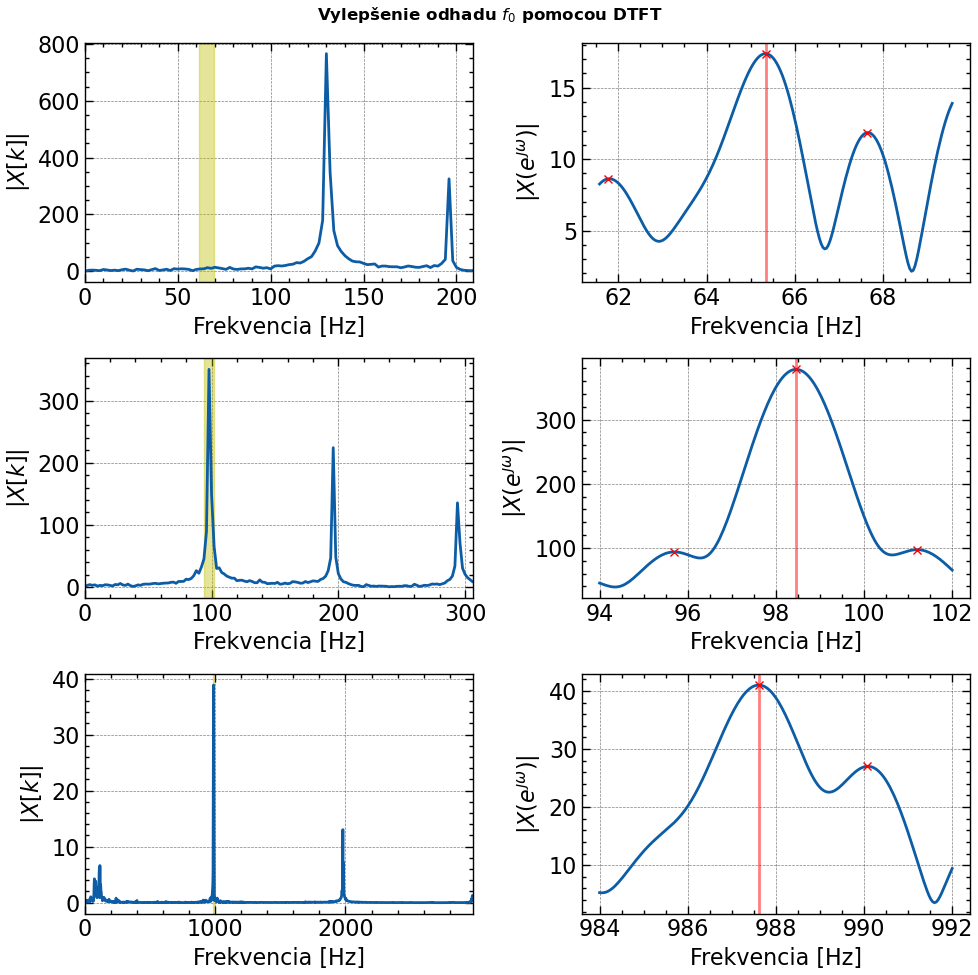

In [47]:
def fundamental_freq_dtft(tone, f0_calc, sample_rate):
    DTFT_FPOINT = 200
    if np.max(tone) == 0:
        return 0.0, None, None, None, None
    # DFT
    tone_dft = fft(tone)
    k_all = np.arange(0, int(len(tone_dft)//2))
    magnitude = np.abs(tone_dft[k_all])
    freq = k_all / len(tone) * sample_rate
    # Interval
    intvl = (f0_calc - 4, f0_calc + 4)
    fsweep = np.linspace(intvl[0], intvl[1], DTFT_FPOINT)
    # DTFT
    omegn = np.zeros([DTFT_FPOINT, len(tone)], dtype='complex')
    for k in np.arange(0, DTFT_FPOINT):
        omegn[k, :] = np.exp(-1j * 2 * np.pi * fsweep[k] /
                             sample_rate * np.arange(0, len(tone)))
    tone_dtft = np.matmul(omegn, tone.T)
    # Nájdenie maxima
    peaks, _ = signal.find_peaks(np.abs(tone_dtft))
    maxpeak_i = np.argmax(np.abs(tone_dtft)[peaks])
    maxpeak_x = fsweep[peaks[maxpeak_i]]
    return maxpeak_x, peaks, tone_dtft, tone_dft, fsweep, intvl


f0_dtft = np.zeros(END_MIDI + 1)
fig, ax = plot.subplots(3, 2, figsize=(10, 10), layout='tight')
fig.suptitle('Vylepšenie odhadu $f_0$ pomocou DTFT', weight='bold')
for i, tone in enumerate(tone_matrix):
    if np.max(tone) == 0:
        continue

    # Výpočet
    f0_dtft[i], peak_all, tone_dtft, tone_dft, freq_all, intvl = fundamental_freq_dtft(
        tone, f0_final[i], sample_rate)
    improvement = abs(MIDI_FREQ[i] - f0_final[i]) - \
        abs(MIDI_FREQ[i] - f0_dtft[i])

    # Vykreslenie
    if (i in MYTONE_MIDI):
        i_plt = MYTONE_MIDI.index(i)

        k_all = np.arange(0, int(len(tone_dft)//2))
        freq_orig = k_all / len(tone) * sample_rate
        ax[i_plt][0].plot(freq_orig, np.abs(tone_dft[k_all]))
        ax[i_plt][0].axvspan(intvl[0], intvl[1], color='y', alpha=0.4)
        ax[i_plt][0].set_xlim(0, intvl[1]*3)
        ax[i_plt][0].set_ylabel('$|X[k]|$')
        ax[i_plt][0].set_xlabel('Frekvencia [Hz]')

        ax[i_plt][1].plot(freq_all, np.abs(tone_dtft))
        ax[i_plt][1].plot(freq_all[peak_all], np.abs(
            tone_dtft)[peak_all], 'rx')
        ax[i_plt][1].axvline(f0_dtft[i], color='r', alpha=0.5,
                             label='$f_0 =$ '+str(round(f0_dtft[i], 2)))
        ax[i_plt][1].set_ylabel('$|X(e^{\jmath \omega})|$')
        ax[i_plt][1].set_xlabel('Frekvencia [Hz]')

f0_final = f0_dtft

<table align="center">
<thead>
  <tr>
    <th colspan="3"><b>Počet zmien po DTFT</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td></td>
    <td><b>Zlepšenie</b></td>
    <td><b>Zhoršenie</b></td>
  </tr>
  <tr>
    <td><b>Veľké<br>(≥0,5 Hz)</b></td>
    <td>18</td>
    <td>14</td>
  </tr>
  <tr>
    <td><b>Malé<br>(&lt;0,5 Hz)</b></td>
    <td>24</td>
    <td>29</td>
  </tr>
</tbody>
</table>

Výsledky DTFT boli zmiešané. Väčšie zmeny nad 0,5 Hz boli skôr k lepšiemu, zatiaľ čo malé zmeny pod 0,5 Hz boli skôr negatívne. Zmeny nepresahovali najväčšiu odchýlku odhadu (2,93 Hz).

# 4: Reprezentácia klavíru

In [48]:
def get_dtft_mag_phase(tone, center, sample_rate):
    DTFT_RANGE = 10
    DTFT_POINT = 200
    if np.max(tone) == 0:
        return 0.0, 0.0
    # DFT
    tone_dft = fft(tone)
    k_all = np.arange(0, int(len(tone_dft)//2))
    magnitude = np.abs(tone_dft[k_all])
    phase = np.angle(tone_dft[k_all])
    freq = k_all / len(tone) * sample_rate
    # Interval
    intvl = (center - DTFT_RANGE, center + DTFT_RANGE)
    fsweep = np.linspace(intvl[0], intvl[1], DTFT_POINT)
    # DTFT
    omegn = np.zeros([DTFT_FPOINT, len(tone)], dtype='complex')
    for k in np.arange(0, DTFT_FPOINT):
        omegn[k, :] = np.exp(-1j * 2 * np.pi * fsweep[k] /
                             sample_rate * np.arange(0, len(tone)))
    tone_dtft = np.matmul(omegn, tone.T)
    module = fsweep[np.argmax(np.abs(tone_dtft))]
    return module, phase